In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from functools import partial

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.config import Config
from src.episode import Episode
from src.episode_dataset import EpisodeDataset
from src.policy import Policy
from src.reward_model import RewardModel
from src.grpo_trainer import GRPOTrainer
from src.policy_model_utils import load_policy_model, save_policy_model, train_and_plot_policy, inference_and_plot_policy
from src.utils import get_color, normalize_min_max, to_device_collate, top_k_sampling
from src.episode_batch_reat_sampler import EpisodeBatchRepeatSampler

# Setup
---

In [2]:
config = Config()
reward_model = RewardModel(config=config)

# Datasets

train_dataset = EpisodeDataset(config=config, split="TRAIN")
print(f"train_dataset : {len(train_dataset)}")

test_dataset = EpisodeDataset(config=config, split="TEST")
print(f"test_dataset : {len(test_dataset)}")

eval_dataset = EpisodeDataset(config=config, split="EVAL")
print(f"eval_dataset : {len(eval_dataset)}")


# DataLoaders
def get_data_loader(
    dataset: EpisodeDataset, batch_size: int, group_size: int, repeats: int
):
    batch_repeat_sampler = EpisodeBatchRepeatSampler(
        dataset=dataset,
        batch_size=batch_size,
        group_size=group_size,
        repeats=repeats,
    )
    print(
        f"batch_repeat_sampler: {len(batch_repeat_sampler)},  {list(batch_repeat_sampler)}"
    )
    print(
        f"batch ids: {[e.id for e in dataset.get_episods(batch_episode_idices=list(batch_repeat_sampler))]}"
    )

    to_device_collate_configurable = partial(to_device_collate, config.device)
    dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size * group_size,
        sampler=batch_repeat_sampler,
        collate_fn=to_device_collate_configurable,
    )
    print(f"data loader: {dataset.split}, {len(dataloader)}")
    return dataloader


train_dataloader = get_data_loader(
    dataset=train_dataset,
    batch_size=config.train_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)
test_dataloader = get_data_loader(
    dataset=test_dataset,
    batch_size=config.test_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

eval_dataloader = get_data_loader(
    dataset=eval_dataset,
    batch_size=config.eval_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

train_dataset : 50000
test_dataset : 500
eval_dataset : 5000
batch_repeat_sampler: 100000,  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 20

In [3]:
# for idx, batch_data in enumerate(train_dataloader):
#     batch_episode_idices = batch_data.get("episode_idx")
#     print(
#         f"idx: {idx}, batch_items: {len(batch_episode_idices)}, batch ids: {[e.id for e in train_dataset.get_episods(batch_episode_idices=batch_episode_idices)]}"
#     )

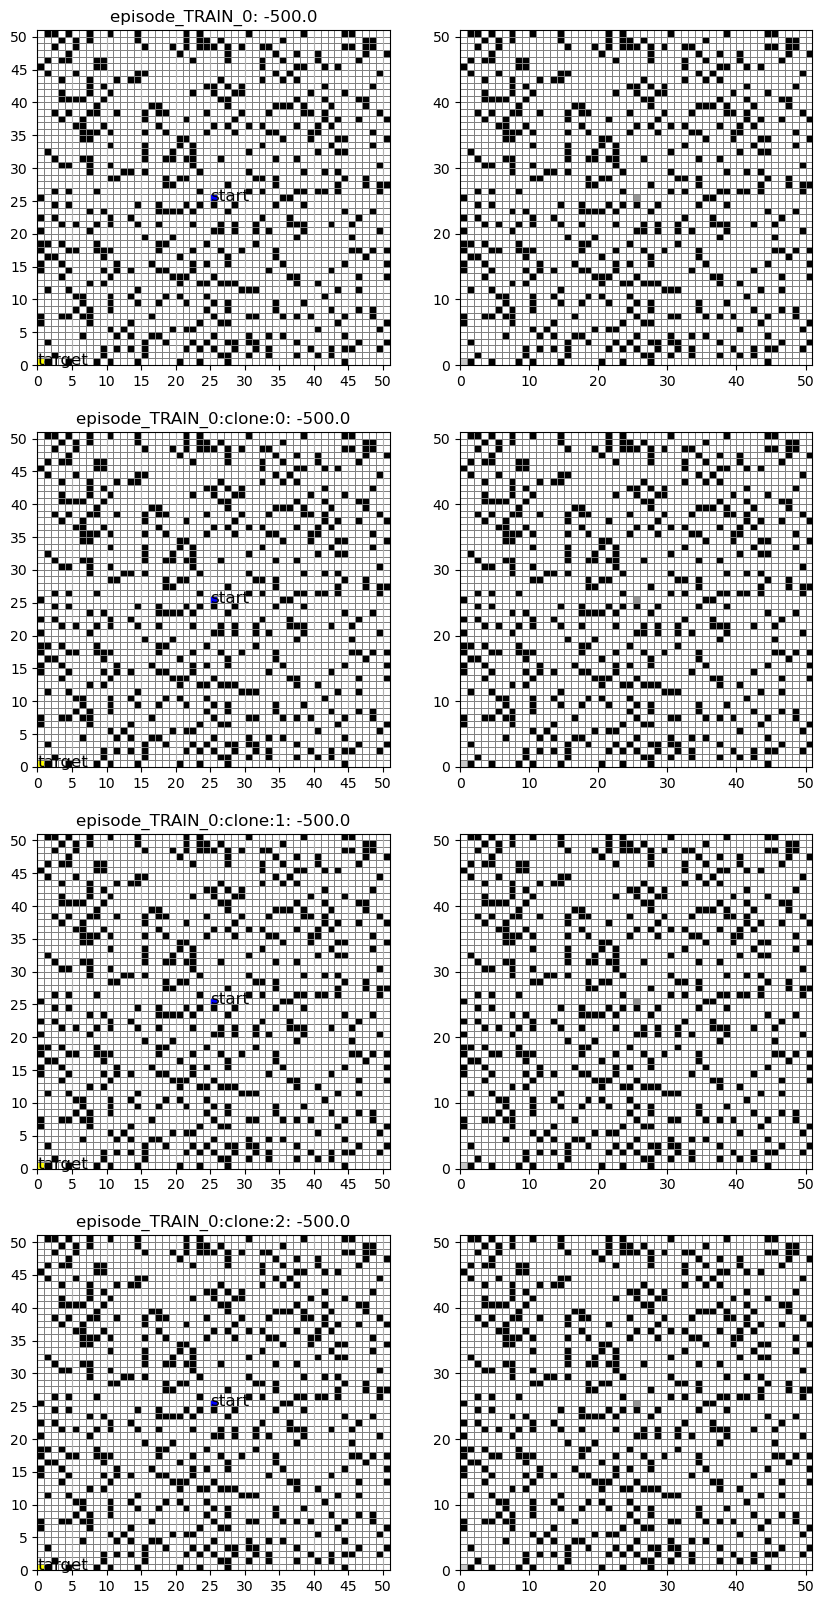

In [4]:
episode_samples = 4
fig, axes = plt.subplots(nrows=episode_samples, ncols=2, figsize=(10, 20))

for eidx in range(episode_samples):
    es = train_dataset.get_episode(eidx)

    es.viz(ax=axes[eidx][0], reward_model=reward_model)

    # Viz fov
    fov = es.fov(center_pos=es.agent.start_state.position())
    # print(f"fov: {fov.size()}, {fov}")
    # print(f"fov: {fov}")
    es.viz_fov(ax=axes[eidx][1])
plt.show()

step: 0, logits: tensor([[ 146.2795,  134.0358,  307.4751,   39.5737,  -94.4286, -208.8123,
          501.5283,  161.3884, -260.0176]]), logit_prob: tensor([[0.1844]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[6]]), state: tensor([26, 24]), action_history: [tensor(6)]
step: 1, logits: tensor([[ 307.5038,  375.9289,  194.9441, -112.4511,  -71.1149, -333.9090,
          497.5059,  256.1974,  -27.2776]]), logit_prob: tensor([[0.1670]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[6]]), state: tensor([27, 23]), action_history: [tensor(6), tensor(6)]
step: 2, logits: tensor([[ 122.3265,  157.6719,  198.8787,   42.2697,  -60.3557, -333.7155,
          442.0669,  368.6950, -172.5460]]), logit_prob: tensor([[0.1684]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[6]]), state: tensor([28, 22]), action_history: [tensor(6), tensor(6), tensor(6)]
step: 3, logits: tensor([[ 335.0451,  244.4622,   57.1348,  134.3047, -173.1708, -216.1768,
          629.4330,  298.7414,   84.4588]]),

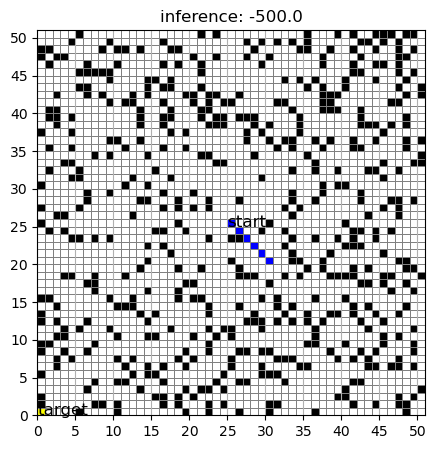

In [5]:
test_policy = Policy(config=config)
episode = inference_and_plot_policy(
    policy=test_policy, config=config, reward_model=reward_model, steps=5, debug=True
)
# episode.agent.action_history

In [6]:
# np.linalg.norm([8, 6], ord=1)
episode.reward(reward_model=reward_model)

tensor(-500.)

# Training Loop
---

In [7]:
policy = Policy(config=config)
reward_model = RewardModel(config=config)
trainer = GRPOTrainer(config=config, policy=policy, reward_model=reward_model)

step: 0, logits: tensor([[ -73.6145,  151.7198, -233.9097, -194.4214,   99.6951,   85.7490,
          251.8301,  302.2563,  -96.2069]]), logit_prob: tensor([[0.1738]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([26, 25]), action_history: [tensor(7)]
step: 1, logits: tensor([[  73.4397, -269.2020, -237.0183, -170.5402, -273.1418,  293.4604,
          283.1756,  428.6658, -289.9517]]), logit_prob: tensor([[0.1920]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([27, 25]), action_history: [tensor(7), tensor(7)]
step: 2, logits: tensor([[ 104.1121,  -82.8339, -143.1370, -161.5959, -111.2204,  207.6891,
          314.0244,  501.7913, -338.2244]]), logit_prob: tensor([[0.1854]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([28, 25]), action_history: [tensor(7), tensor(7), tensor(7)]
step: 3, logits: tensor([[-134.6016, -390.1864, -158.7324,  203.0632,  -89.6421,  136.3591,
          115.4463,  486.7385, -367.5991]]),

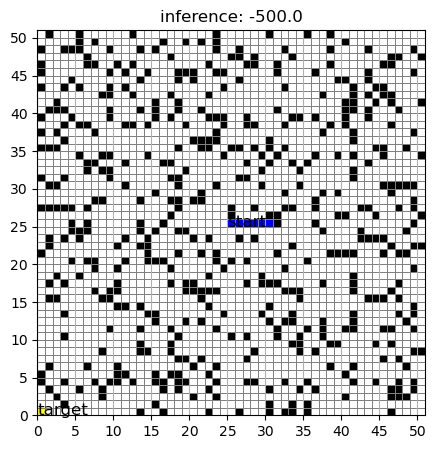

In [8]:
# Before tarin, policy behavior
episode = inference_and_plot_policy(
    policy=policy, config=config, reward_model=reward_model, steps=5, debug=True
)

In [9]:
# plt.ioff()
trainer.run(train_dataset=train_dataset, eval_dataset=eval_dataset, debug=False)
save_policy_model(policy=policy)

# plt.ion()

batch_repeat_sampler: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 21

Epoch 1: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s, should_run_optimization=1, current_batch_episode_idx=[2450000, 2450001, 2450002, 2450003, 2450004, 2450005, 2450006, 2450007, 2450008, 2450009, 2450010, 2450011, 2450012, 2450013, 2450014, 2450015, 2450016, 2450017, 2450018, 2450019, 2450020, 2450021, 2450022, 2450023, 2450024, 2450025, 2450026, 2450027, 2450028, 2450029, 2450030, 2450031, 2450032, 2450033, 2450034, 2450035, 2450036, 2450037, 2450038, 2450039, 2450040, 2450041, 2450042, 2450043, 2450044, 2450045, 2450046, 2450047, 2450048, 2450049, 2450050, 2450051, 2450052, 2450053, 2450054, 2450055, 2450056, 2450057, 2450058, 2450059, 2450060, 2450061, 2450062, 2450063, 2450064, 2450065, 2450066, 2450067, 2450068, 2450069, 2450070, 2450071, 2450072, 2450073, 2450074, 2450075, 2450076, 2450077, 2450078, 2450079, 2450080, 2450081, 2450082, 2450083, 2450084, 2450085, 2450086, 2450087, 2450088, 2450089, 2450090, 2450091, 2450092, 2450093, 2450094, 2450095, 2450096, 2450097, 24500

model_path: rf_model_policy_20250511040725.pt
Save policy model to: rf_model_policy_20250511040725.pt


step: 0, logits: tensor([[ 3.6626e+10,  2.6014e+10,  4.1121e+10,  2.2657e+10,  4.6710e+10,
          2.3139e+10, -4.0873e+11,  6.4225e+10,  3.5084e+10]]), logit_prob: tensor([[0.1262]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([26, 25]), action_history: [tensor(7)]
step: 1, logits: tensor([[ 3.6125e+10,  2.5532e+10,  4.0416e+10,  2.2354e+10,  4.5998e+10,
          2.2819e+10, -4.0219e+11,  6.3157e+10,  3.4459e+10]]), logit_prob: tensor([[0.1262]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([27, 25]), action_history: [tensor(7), tensor(7)]
step: 2, logits: tensor([[ 3.5367e+10,  2.5001e+10,  3.9581e+10,  2.1884e+10,  4.5042e+10,
          2.2343e+10, -3.9383e+11,  6.1840e+10,  3.3750e+10]]), logit_prob: tensor([[0.1262]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[7]]), state: tensor([28, 25]), action_history: [tensor(7), tensor(7), tensor(7)]
step: 3, logits: tensor([[ 3.4646e+10,  2.4487e+10,  3.8753e+10,  2.1415e+10,  4.4

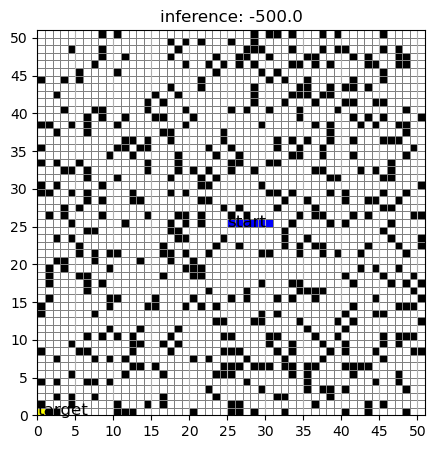

episode reward: -500.0


In [10]:
# post model training
episode = inference_and_plot_policy(
    policy=policy, config=config, reward_model=reward_model, steps=5, debug=True
)
print(f"episode reward: {episode.reward(reward_model=reward_model)}")

In [11]:
print(f"episode reward: {episode.reward(reward_model=reward_model)}")

episode reward: -500.0


# Evaluate the Model
----

step: 0, logits: tensor([[ 2.1075e+07, -1.0567e+06, -2.6875e+08, -5.2559e+06,  2.1564e+07,
          4.0596e+07,  4.1027e+07,  4.2103e+07,  4.5008e+07]]), logit_prob: tensor([[0.1265]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[8]]), state: tensor([26, 26]), action_history: [tensor(8)]
step: 1, logits: tensor([[ 1.9371e+07, -9.7123e+05, -2.4702e+08, -4.8310e+06,  1.9820e+07,
          3.7313e+07,  3.7710e+07,  3.8699e+07,  4.1369e+07]]), logit_prob: tensor([[0.1265]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[8]]), state: tensor([27, 27]), action_history: [tensor(8), tensor(8)]
step: 2, logits: tensor([[ 1.7978e+07, -9.0141e+05, -2.2926e+08, -4.4837e+06,  1.8395e+07,
          3.4631e+07,  3.4999e+07,  3.5917e+07,  3.8395e+07]]), logit_prob: tensor([[0.1265]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[8]]), state: tensor([28, 28]), action_history: [tensor(8), tensor(8), tensor(8)]
step: 3, logits: tensor([[ 1.7108e+07, -8.5777e+05, -2.1816e+08, -4.2666e+06,  1.7

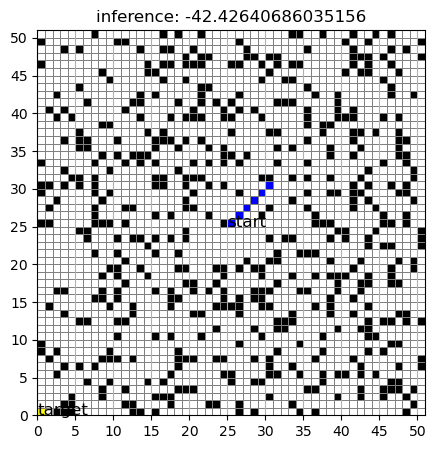

In [13]:
policy_model_path = (
    "/Users/chengbai/ml/cheng_git/rf_agent/rf_model_policy_20250510230738_base.pt"
)
trained_policy = load_policy_model(config=config, policy_model_path=policy_model_path)
assert trained_policy is not None

episode = inference_and_plot_policy(
    policy=trained_policy, config=config, reward_model=reward_model, steps=5, debug=True
)